In [1]:
import os
from pathlib import Path
from typing import Callable, Optional, List, Tuple

from PIL import Image
from torch.utils.data import Dataset

In [2]:
import torchvision.transforms as transforms
import csv 

class AgeDataset(Dataset):
   
    def __init__(
        self,
        root: str | Path,
        split: str = "train",
        transform: Optional[Callable] = None,
        extensions: Tuple[str, ...] = (".png", ".jpg", ".jpeg"),
    ):
        self.root = Path(root)
        self.split = split
        self.transform = transform
        self.extensions = tuple(e.lower() for e in extensions)

        self.samples = self._load_from_dirs()

    def _load_from_dirs(self) -> List[Tuple[Path, int]]:
        split_dir = self.root / "JPGs"
        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        samples: List[Tuple[Path, int]] = []

        csv_path = self.root / "trainingdata.csv" if self.split =="train" else self.root / "testdata.csv"
        with csv_path.open("r", newline="", encoding="utf-8") as f:
            reader = csv.reader(f)
            for row in reader:
                if not row or len(row) < 2:
                    continue
                fname = row[0].strip()
                try:
                    label = int(row[1].strip())
                except ValueError:
                    # Likely a header like "filename,label" — skip
                    continue

                img_path = split_dir / fname
                if not img_path.exists():
                    raise FileNotFoundError(f"Missing image: {img_path}")
                    

                samples.append((img_path, label))
        return samples


    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        img = Image.open(path).convert("RGB")  # dataset is RGB PNGs
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [3]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects 224x224
    transforms.Grayscale(num_output_channels=3),  # for MNIST, remove if dataset is already RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
train_dataset = AgeDataset(
    root='XPAge01_RGB/XP',
    split='test',
    transform=transform

)
test_dataset = AgeDataset(
    root='XPAge01_RGB/XP',
    split='train',
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


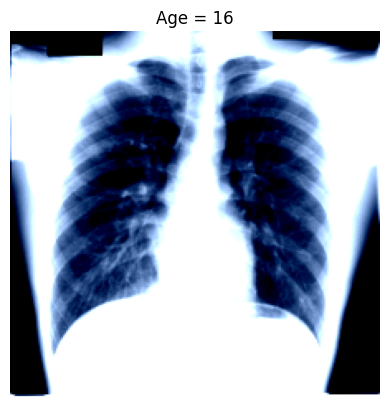

In [12]:
img, label = train_dataset[0]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))   # convert CHW → HWC
plt.title(f"Age = {label}")
plt.axis("off")
plt.show()

In [13]:
import torch
from torch.utils.data import DataLoader

# sensible defaults
BATCH_SIZE = 8
IS_TRAIN = True

# tip: on Mac M1 use num_workers=0; on Linux/GPU you can raise it (e.g., 4)
num_workers = 0  # set to 4–8 on Linux if you want

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # shuffle for training
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # no shuffle for eval
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
)

# --- quick sanity check ---
imgs, labels = next(iter(train_loader))
print("Train batch:", imgs.shape, labels.shape)  # e.g., torch.Size([64, 3, 128, 128]) torch.Size([64])


Train batch: torch.Size([8, 3, 224, 224]) torch.Size([8])


In [14]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# -------------------- EVAL / TEST (REGRESSION) --------------------
def test(model, test_loader, device):
    """
    Computes MSE, RMSE, MAE, and R^2 for regression.
    Assumes model outputs shape [B, 1] and labels are scalars.
    """
    model.eval()

    sse = 0.0           # sum of squared errors
    mae_sum = 0.0       # sum of absolute errors
    y_sum = 0.0         # sum of targets
    y2_sum = 0.0        # sum of squares of targets
    n = 0               # number of samples

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            y = labels.to(device, dtype=torch.float32).view(-1)       # [B]

            preds = model(images).squeeze(1)                          # [B]

            err = preds - y
            sse += (err ** 2).sum().item()
            mae_sum += err.abs().sum().item()
            y_sum += y.sum().item()
            y2_sum += (y ** 2).sum().item()
            n += y.numel()

    mse = sse / max(n, 1)
    rmse = math.sqrt(mse)
    mae = mae_sum / max(n, 1)
    # SST via one-pass stats: sum((y - ybar)^2) = sum(y^2) - n*ybar^2
    sst = max(y2_sum - (y_sum * y_sum) / max(n, 1), 0.0)
    r2 = 1.0 - (sse / (sst + 1e-12))

    print(f"✅ Test MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return mse, rmse, mae, r2


# -------------------- TRAIN (REGRESSION) --------------------
def train(num_epochs, model, train_loader, test_loader, device, optimizer, criterion):
    """
    Trains a frozen-backbone regression head with MSE (or SmoothL1).
    Expects:
      - model outputs [B,1]
      - labels are floats (scalars)
      - criterion is a regression loss (e.g., nn.MSELoss())
    """
    total_step = len(train_loader)
    train_mses = []
    test_mses, test_r2s = [], []

    for epoch in range(num_epochs):
        # Train only the head (keep backbone frozen / BN stats fixed if that’s your setup)
        model.train()
        running_mse = 0.0

        for i, (imgs, labels) in tqdm(enumerate(train_loader), total=total_step, leave=False):
            imgs = imgs.to(device)
            y = labels.to(device, dtype=torch.float32).view(-1)   # [B]

            optimizer.zero_grad()
            preds = model(imgs).squeeze(1)                        # [B]
            loss = criterion(preds, y)                            # e.g., MSELoss
            loss.backward()
            optimizer.step()

            running_mse += loss.item()

            if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], MSE: {loss.item():.4f}")

        avg_train_mse = running_mse / max(total_step, 1)
        train_mses.append(avg_train_mse)

        test_mse, test_rmse, test_mae, test_r2 = test(model, test_loader, device)
        test_mses.append(test_mse)
        test_r2s.append(test_r2)

        print(f"Epoch [{epoch+1}/{num_epochs}] Avg Train MSE: {avg_train_mse:.4f}")

    # ---- Plots ----
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_mses, marker='o', label="Train MSE")
    plt.plot(range(1, num_epochs+1), test_mses, marker='s', label="Test MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Train vs Test MSE")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(range(1, num_epochs+1), test_r2s, marker='o')
    plt.xlabel("Epoch"); plt.ylabel("R²"); plt.title("Test R² by Epoch")
    plt.grid(True); plt.show()

    return train_mses


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Replace final head: 1 output for regression (no activation here)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, 1)

model = model.to(device)

# Keep BN stats frozen (like you had)
model.eval()          # backbone stays eval
model.fc.train()      # only the new head trains

# ----- Loss & optimizer -----
# Choose one:
criterion = nn.MSELoss()                  # or: nn.SmoothL1Loss(beta=1.0)  # Huber
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


✅ Test MSE: 2166.0708 | RMSE: 46.5411 | MAE: 44.1328 | R²: -9.9401
Epoch [1/50] Avg Train MSE: 3164.7660


✅ Test MSE: 1372.1931 | RMSE: 37.0431 | MAE: 33.7283 | R²: -5.9305
Epoch [2/50] Avg Train MSE: 2219.2812


✅ Test MSE: 926.4348 | RMSE: 30.4374 | MAE: 26.3440 | R²: -3.6791
Epoch [3/50] Avg Train MSE: 1532.9517


✅ Test MSE: 613.3198 | RMSE: 24.7653 | MAE: 20.2527 | R²: -2.0977
Epoch [4/50] Avg Train MSE: 1038.2359


✅ Test MSE: 433.1014 | RMSE: 20.8111 | MAE: 16.7160 | R²: -1.1874
Epoch [5/50] Avg Train MSE: 709.8418


✅ Test MSE: 315.7420 | RMSE: 17.7691 | MAE: 14.5361 | R²: -0.5947
Epoch [6/50] Avg Train MSE: 489.7502


✅ Test MSE: 280.7706 | RMSE: 16.7562 | MAE: 14.0006 | R²: -0.4181
Epoch [7/50] Avg Train MSE: 377.2479


✅ Test MSE: 266.1860 | RMSE: 16.3152 | MAE: 13.7720 | R²: -0.3444
Epoch [8/50] Avg Train MSE: 316.7305


✅ Test MSE: 260.8804 | RMSE: 16.1518 | MAE: 13.6724 | R²: -0.3176
Epoch [9/50] Avg Train MSE: 267.6111


✅ Test MSE: 270.4360 | RMSE: 16.4449 | MAE: 13.8843 | R²: -0.3659
Epoch [10/50] Avg Train MSE: 264.8281


✅ Test MSE: 277.5722 | RMSE: 16.6605 | MAE: 14.0574 | R²: -0.4019
Epoch [11/50] Avg Train MSE: 224.3812


✅ Test MSE: 280.2086 | RMSE: 16.7394 | MAE: 14.0935 | R²: -0.4152
Epoch [12/50] Avg Train MSE: 234.1698


✅ Test MSE: 288.2994 | RMSE: 16.9794 | MAE: 14.2429 | R²: -0.4561
Epoch [13/50] Avg Train MSE: 240.8129


✅ Test MSE: 292.3895 | RMSE: 17.0994 | MAE: 14.3250 | R²: -0.4768
Epoch [14/50] Avg Train MSE: 239.3292


✅ Test MSE: 282.2197 | RMSE: 16.7994 | MAE: 14.0940 | R²: -0.4254
Epoch [15/50] Avg Train MSE: 234.9505


✅ Test MSE: 285.6743 | RMSE: 16.9019 | MAE: 14.1715 | R²: -0.4428
Epoch [16/50] Avg Train MSE: 222.5283


✅ Test MSE: 291.0446 | RMSE: 17.0600 | MAE: 14.2798 | R²: -0.4700
Epoch [17/50] Avg Train MSE: 221.2536


✅ Test MSE: 293.9935 | RMSE: 17.1462 | MAE: 14.3376 | R²: -0.4849
Epoch [18/50] Avg Train MSE: 221.5310


✅ Test MSE: 288.9266 | RMSE: 16.9978 | MAE: 14.2896 | R²: -0.4593
Epoch [19/50] Avg Train MSE: 221.6802


✅ Test MSE: 281.8272 | RMSE: 16.7877 | MAE: 14.0678 | R²: -0.4234
Epoch [20/50] Avg Train MSE: 226.5328


✅ Test MSE: 283.0306 | RMSE: 16.8235 | MAE: 14.0987 | R²: -0.4295
Epoch [21/50] Avg Train MSE: 224.4463


✅ Test MSE: 278.4013 | RMSE: 16.6854 | MAE: 13.9464 | R²: -0.4061
Epoch [22/50] Avg Train MSE: 213.0987


✅ Test MSE: 285.5384 | RMSE: 16.8979 | MAE: 14.1329 | R²: -0.4422
Epoch [23/50] Avg Train MSE: 216.7316


✅ Test MSE: 278.7871 | RMSE: 16.6969 | MAE: 13.9780 | R²: -0.4081
Epoch [24/50] Avg Train MSE: 208.5125


✅ Test MSE: 273.3784 | RMSE: 16.5342 | MAE: 13.8566 | R²: -0.3807
Epoch [25/50] Avg Train MSE: 220.4397


✅ Test MSE: 274.0027 | RMSE: 16.5530 | MAE: 13.9001 | R²: -0.3839
Epoch [26/50] Avg Train MSE: 212.4126


✅ Test MSE: 282.0276 | RMSE: 16.7937 | MAE: 14.0504 | R²: -0.4244
Epoch [27/50] Avg Train MSE: 210.5801


✅ Test MSE: 264.0867 | RMSE: 16.2507 | MAE: 13.5847 | R²: -0.3338
Epoch [28/50] Avg Train MSE: 203.1350


✅ Test MSE: 272.6267 | RMSE: 16.5114 | MAE: 13.8676 | R²: -0.3769
Epoch [29/50] Avg Train MSE: 201.3177


✅ Test MSE: 265.4775 | RMSE: 16.2935 | MAE: 13.6781 | R²: -0.3408
Epoch [30/50] Avg Train MSE: 204.9252


✅ Test MSE: 261.4642 | RMSE: 16.1699 | MAE: 13.5798 | R²: -0.3206
Epoch [31/50] Avg Train MSE: 196.3987


✅ Test MSE: 271.9501 | RMSE: 16.4909 | MAE: 13.7779 | R²: -0.3735
Epoch [32/50] Avg Train MSE: 200.5886


✅ Test MSE: 262.4040 | RMSE: 16.1989 | MAE: 13.5708 | R²: -0.3253
Epoch [33/50] Avg Train MSE: 207.5219


✅ Test MSE: 267.0831 | RMSE: 16.3427 | MAE: 13.6377 | R²: -0.3489
Epoch [34/50] Avg Train MSE: 205.9963


✅ Test MSE: 259.6209 | RMSE: 16.1128 | MAE: 13.4950 | R²: -0.3113
Epoch [35/50] Avg Train MSE: 191.2360


✅ Test MSE: 264.5947 | RMSE: 16.2664 | MAE: 13.6267 | R²: -0.3364
Epoch [36/50] Avg Train MSE: 205.5075


✅ Test MSE: 250.9727 | RMSE: 15.8421 | MAE: 13.3196 | R²: -0.2676
Epoch [37/50] Avg Train MSE: 189.3975


✅ Test MSE: 247.1520 | RMSE: 15.7211 | MAE: 13.1927 | R²: -0.2483
Epoch [38/50] Avg Train MSE: 201.2443


✅ Test MSE: 248.7670 | RMSE: 15.7723 | MAE: 13.2611 | R²: -0.2564
Epoch [39/50] Avg Train MSE: 184.3534


✅ Test MSE: 252.1311 | RMSE: 15.8786 | MAE: 13.3083 | R²: -0.2734
Epoch [40/50] Avg Train MSE: 183.8141


✅ Test MSE: 248.8636 | RMSE: 15.7754 | MAE: 13.2078 | R²: -0.2569
Epoch [41/50] Avg Train MSE: 183.9013


✅ Test MSE: 243.7717 | RMSE: 15.6132 | MAE: 13.1077 | R²: -0.2312
Epoch [42/50] Avg Train MSE: 185.2579


✅ Test MSE: 247.2773 | RMSE: 15.7251 | MAE: 13.1913 | R²: -0.2489
Epoch [43/50] Avg Train MSE: 192.2502


✅ Test MSE: 244.1758 | RMSE: 15.6261 | MAE: 13.0545 | R²: -0.2332
Epoch [44/50] Avg Train MSE: 192.3863


✅ Test MSE: 247.5972 | RMSE: 15.7352 | MAE: 13.1756 | R²: -0.2505
Epoch [45/50] Avg Train MSE: 180.7417


✅ Test MSE: 249.7143 | RMSE: 15.8024 | MAE: 13.2355 | R²: -0.2612
Epoch [46/50] Avg Train MSE: 178.9216


✅ Test MSE: 243.7911 | RMSE: 15.6138 | MAE: 13.0770 | R²: -0.2313
Epoch [47/50] Avg Train MSE: 180.6756


✅ Test MSE: 244.3419 | RMSE: 15.6314 | MAE: 13.1250 | R²: -0.2341
Epoch [48/50] Avg Train MSE: 177.9897


✅ Test MSE: 232.6632 | RMSE: 15.2533 | MAE: 12.7482 | R²: -0.1751
Epoch [49/50] Avg Train MSE: 178.5161


✅ Test MSE: 235.3623 | RMSE: 15.3415 | MAE: 12.8549 | R²: -0.1887
Epoch [50/50] Avg Train MSE: 170.2608


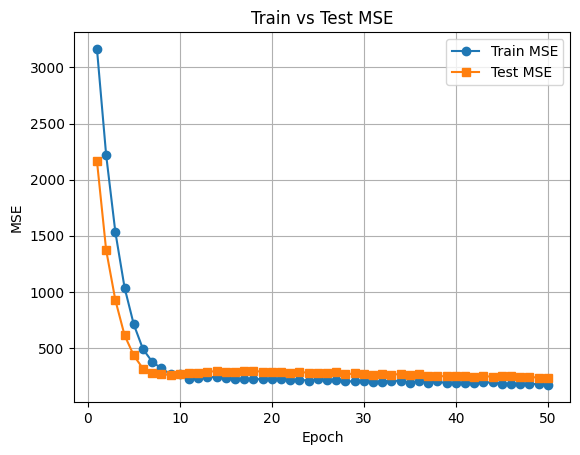

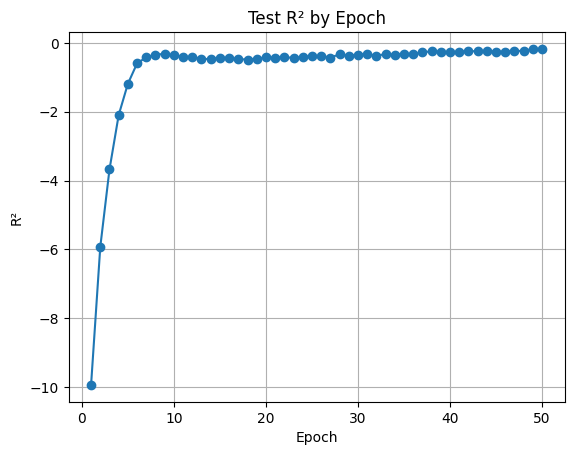

In [16]:


history = train(
    num_epochs=50,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


# Replace final head: 1 output for regression (no activation here)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, 1)

for p in model.parameters():
    p.requires_grad = False

last_conv = model.layer4[-1].conv2
for p in last_conv.parameters():
    p.requires_grad = True

for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)

# --- 5) Keep BN stats frozen (global eval), but train the two modules we care about ---
model.eval()            # freeze BN running stats across the net
last_conv.train()       # allow grads in last conv
model.fc.train()        # allow grads in classifier


# ----- Loss & optimizer -----
# Choose one:
criterion = nn.MSELoss()                  # or: nn.SmoothL1Loss(beta=1.0)  # Huber
optimizer = optim.Adam(
    [
        {"params": last_conv.parameters(), "lr": 1e-5},
        {"params": model.fc.parameters(), "lr": 1e-4},
    ],
    weight_decay=1e-4,
)

✅ Test MSE: 3203.9821 | RMSE: 56.6037 | MAE: 54.9559 | R²: -15.1822
Epoch [1/100] Avg Train MSE: 3749.6575


✅ Test MSE: 2761.1885 | RMSE: 52.5470 | MAE: 50.9533 | R²: -12.9458
Epoch [2/100] Avg Train MSE: 3422.4591


✅ Test MSE: 2814.1880 | RMSE: 53.0489 | MAE: 51.6062 | R²: -13.2135
Epoch [3/100] Avg Train MSE: 3244.5670


✅ Test MSE: 2758.5428 | RMSE: 52.5218 | MAE: 51.1535 | R²: -12.9324
Epoch [4/100] Avg Train MSE: 3070.1594


✅ Test MSE: 2468.2851 | RMSE: 49.6818 | MAE: 48.3023 | R²: -11.4664
Epoch [5/100] Avg Train MSE: 2901.4232


✅ Test MSE: 2243.3236 | RMSE: 47.3637 | MAE: 45.9844 | R²: -10.3302
Epoch [6/100] Avg Train MSE: 2792.5806


✅ Test MSE: 2370.0080 | RMSE: 48.6827 | MAE: 47.2147 | R²: -10.9701
Epoch [7/100] Avg Train MSE: 2675.8831


✅ Test MSE: 2168.9137 | RMSE: 46.5716 | MAE: 45.2674 | R²: -9.9544
Epoch [8/100] Avg Train MSE: 2597.2102


✅ Test MSE: 2146.5260 | RMSE: 46.3306 | MAE: 45.0485 | R²: -9.8413
Epoch [9/100] Avg Train MSE: 2463.3881


✅ Test MSE: 2074.6764 | RMSE: 45.5486 | MAE: 44.3594 | R²: -9.4785
Epoch [10/100] Avg Train MSE: 2352.9666


✅ Test MSE: 1979.8188 | RMSE: 44.4952 | MAE: 43.2631 | R²: -8.9994
Epoch [11/100] Avg Train MSE: 2248.6581


✅ Test MSE: 1809.0758 | RMSE: 42.5332 | MAE: 41.2431 | R²: -8.1370
Epoch [12/100] Avg Train MSE: 2155.0038


✅ Test MSE: 2047.3307 | RMSE: 45.2474 | MAE: 44.0440 | R²: -9.3403
Epoch [13/100] Avg Train MSE: 2054.2919


✅ Test MSE: 1652.4882 | RMSE: 40.6508 | MAE: 39.4106 | R²: -7.3461
Epoch [14/100] Avg Train MSE: 1961.1355


✅ Test MSE: 1498.8226 | RMSE: 38.7146 | MAE: 37.4564 | R²: -6.5700
Epoch [15/100] Avg Train MSE: 1834.7712


✅ Test MSE: 1500.7628 | RMSE: 38.7397 | MAE: 37.4606 | R²: -6.5798
Epoch [16/100] Avg Train MSE: 1744.4040


✅ Test MSE: 1351.8315 | RMSE: 36.7673 | MAE: 35.3992 | R²: -5.8276
Epoch [17/100] Avg Train MSE: 1651.0709


✅ Test MSE: 1409.6741 | RMSE: 37.5456 | MAE: 36.2597 | R²: -6.1198
Epoch [18/100] Avg Train MSE: 1560.4502


✅ Test MSE: 1380.0334 | RMSE: 37.1488 | MAE: 35.9371 | R²: -5.9701
Epoch [19/100] Avg Train MSE: 1457.4540


✅ Test MSE: 1133.2264 | RMSE: 33.6634 | MAE: 32.0962 | R²: -4.7235
Epoch [20/100] Avg Train MSE: 1375.2850


✅ Test MSE: 1239.8437 | RMSE: 35.2114 | MAE: 33.9282 | R²: -5.2620
Epoch [21/100] Avg Train MSE: 1300.5217


✅ Test MSE: 951.8753 | RMSE: 30.8525 | MAE: 29.2634 | R²: -3.8076
Epoch [22/100] Avg Train MSE: 1205.4541


✅ Test MSE: 1030.8334 | RMSE: 32.1066 | MAE: 30.7138 | R²: -4.2064
Epoch [23/100] Avg Train MSE: 1108.7024


✅ Test MSE: 1029.2612 | RMSE: 32.0821 | MAE: 30.7287 | R²: -4.1984
Epoch [24/100] Avg Train MSE: 1032.5181


✅ Test MSE: 681.2364 | RMSE: 26.1005 | MAE: 24.2683 | R²: -2.4407
Epoch [25/100] Avg Train MSE: 952.3876


✅ Test MSE: 794.4198 | RMSE: 28.1855 | MAE: 26.6549 | R²: -3.0123
Epoch [26/100] Avg Train MSE: 870.5525


✅ Test MSE: 804.3095 | RMSE: 28.3604 | MAE: 26.8071 | R²: -3.0623
Epoch [27/100] Avg Train MSE: 811.9053


✅ Test MSE: 528.7952 | RMSE: 22.9955 | MAE: 20.9702 | R²: -1.6708
Epoch [28/100] Avg Train MSE: 742.6027


✅ Test MSE: 556.7532 | RMSE: 23.5956 | MAE: 21.7542 | R²: -1.8120
Epoch [29/100] Avg Train MSE: 667.9908


✅ Test MSE: 500.5053 | RMSE: 22.3720 | MAE: 20.3758 | R²: -1.5279
Epoch [30/100] Avg Train MSE: 629.6841


✅ Test MSE: 696.8379 | RMSE: 26.3977 | MAE: 24.8327 | R²: -2.5195
Epoch [31/100] Avg Train MSE: 563.5009


✅ Test MSE: 472.6472 | RMSE: 21.7405 | MAE: 19.5028 | R²: -1.3872
Epoch [32/100] Avg Train MSE: 515.5597


✅ Test MSE: 379.1266 | RMSE: 19.4712 | MAE: 17.1637 | R²: -0.9148
Epoch [33/100] Avg Train MSE: 474.4383


✅ Test MSE: 305.6271 | RMSE: 17.4822 | MAE: 15.1647 | R²: -0.5436
Epoch [34/100] Avg Train MSE: 407.8864


✅ Test MSE: 476.8102 | RMSE: 21.8360 | MAE: 19.4966 | R²: -1.4082
Epoch [35/100] Avg Train MSE: 384.8626


✅ Test MSE: 257.7262 | RMSE: 16.0539 | MAE: 13.7672 | R²: -0.3017
Epoch [36/100] Avg Train MSE: 328.4124


✅ Test MSE: 315.4674 | RMSE: 17.7614 | MAE: 15.0824 | R²: -0.5933
Epoch [37/100] Avg Train MSE: 316.5744


✅ Test MSE: 218.2383 | RMSE: 14.7729 | MAE: 12.5503 | R²: -0.1022
Epoch [38/100] Avg Train MSE: 261.9918


✅ Test MSE: 209.4669 | RMSE: 14.4730 | MAE: 12.1184 | R²: -0.0579
Epoch [39/100] Avg Train MSE: 244.4915


✅ Test MSE: 201.9530 | RMSE: 14.2110 | MAE: 11.9527 | R²: -0.0200
Epoch [40/100] Avg Train MSE: 213.5241


✅ Test MSE: 214.7613 | RMSE: 14.6547 | MAE: 12.1096 | R²: -0.0847
Epoch [41/100] Avg Train MSE: 202.1441


✅ Test MSE: 135.5071 | RMSE: 11.6407 | MAE: 9.6373 | R²: 0.3156
Epoch [42/100] Avg Train MSE: 164.0983


✅ Test MSE: 140.6383 | RMSE: 11.8591 | MAE: 9.9862 | R²: 0.2897
Epoch [43/100] Avg Train MSE: 149.1442


✅ Test MSE: 146.2263 | RMSE: 12.0924 | MAE: 9.9567 | R²: 0.2615
Epoch [44/100] Avg Train MSE: 121.3683


✅ Test MSE: 124.7468 | RMSE: 11.1690 | MAE: 9.1786 | R²: 0.3699
Epoch [45/100] Avg Train MSE: 112.8682


✅ Test MSE: 141.2098 | RMSE: 11.8832 | MAE: 9.7699 | R²: 0.2868
Epoch [46/100] Avg Train MSE: 96.9200


✅ Test MSE: 115.6590 | RMSE: 10.7545 | MAE: 8.7655 | R²: 0.4158
Epoch [47/100] Avg Train MSE: 101.8502


✅ Test MSE: 89.9303 | RMSE: 9.4832 | MAE: 7.6136 | R²: 0.5458
Epoch [48/100] Avg Train MSE: 85.5808


✅ Test MSE: 132.9710 | RMSE: 11.5313 | MAE: 9.6398 | R²: 0.3284
Epoch [49/100] Avg Train MSE: 68.1234


✅ Test MSE: 99.7260 | RMSE: 9.9863 | MAE: 7.9061 | R²: 0.4963
Epoch [50/100] Avg Train MSE: 69.2156


✅ Test MSE: 88.7788 | RMSE: 9.4222 | MAE: 7.5377 | R²: 0.5516
Epoch [51/100] Avg Train MSE: 75.0923


✅ Test MSE: 82.7076 | RMSE: 9.0944 | MAE: 7.1445 | R²: 0.5823
Epoch [52/100] Avg Train MSE: 46.5825


✅ Test MSE: 105.3938 | RMSE: 10.2662 | MAE: 8.2715 | R²: 0.4677
Epoch [53/100] Avg Train MSE: 48.6722


✅ Test MSE: 92.4004 | RMSE: 9.6125 | MAE: 7.7355 | R²: 0.5333
Epoch [54/100] Avg Train MSE: 41.0240


✅ Test MSE: 81.2496 | RMSE: 9.0139 | MAE: 7.2301 | R²: 0.5896
Epoch [55/100] Avg Train MSE: 46.1051


✅ Test MSE: 77.1082 | RMSE: 8.7811 | MAE: 6.8124 | R²: 0.6106
Epoch [56/100] Avg Train MSE: 25.8894


✅ Test MSE: 82.4480 | RMSE: 9.0801 | MAE: 7.3306 | R²: 0.5836
Epoch [57/100] Avg Train MSE: 28.0374


✅ Test MSE: 81.7576 | RMSE: 9.0420 | MAE: 7.3384 | R²: 0.5871
Epoch [58/100] Avg Train MSE: 23.2265


✅ Test MSE: 77.6733 | RMSE: 8.8132 | MAE: 6.6762 | R²: 0.6077
Epoch [59/100] Avg Train MSE: 28.4647


✅ Test MSE: 84.9493 | RMSE: 9.2168 | MAE: 7.3582 | R²: 0.5710
Epoch [60/100] Avg Train MSE: 30.0601


✅ Test MSE: 67.5205 | RMSE: 8.2171 | MAE: 6.4017 | R²: 0.6590
Epoch [61/100] Avg Train MSE: 25.5242


✅ Test MSE: 87.0087 | RMSE: 9.3278 | MAE: 7.6120 | R²: 0.5605
Epoch [62/100] Avg Train MSE: 20.2388


✅ Test MSE: 83.3768 | RMSE: 9.1311 | MAE: 7.2761 | R²: 0.5789
Epoch [63/100] Avg Train MSE: 20.7052


✅ Test MSE: 85.2173 | RMSE: 9.2313 | MAE: 7.4666 | R²: 0.5696
Epoch [64/100] Avg Train MSE: 24.1721


✅ Test MSE: 78.9823 | RMSE: 8.8872 | MAE: 7.1725 | R²: 0.6011
Epoch [65/100] Avg Train MSE: 25.0094


✅ Test MSE: 83.1232 | RMSE: 9.1172 | MAE: 7.3061 | R²: 0.5802
Epoch [66/100] Avg Train MSE: 33.5227


✅ Test MSE: 81.8956 | RMSE: 9.0496 | MAE: 7.2724 | R²: 0.5864
Epoch [67/100] Avg Train MSE: 21.6077


✅ Test MSE: 75.7537 | RMSE: 8.7037 | MAE: 6.9984 | R²: 0.6174
Epoch [68/100] Avg Train MSE: 15.4702


✅ Test MSE: 81.2457 | RMSE: 9.0136 | MAE: 7.2506 | R²: 0.5897
Epoch [69/100] Avg Train MSE: 14.5780


✅ Test MSE: 77.9601 | RMSE: 8.8295 | MAE: 7.1850 | R²: 0.6063
Epoch [70/100] Avg Train MSE: 22.7450


✅ Test MSE: 83.2190 | RMSE: 9.1224 | MAE: 7.3117 | R²: 0.5797
Epoch [71/100] Avg Train MSE: 19.6707


✅ Test MSE: 89.9305 | RMSE: 9.4832 | MAE: 7.7854 | R²: 0.5458
Epoch [72/100] Avg Train MSE: 15.0041


✅ Test MSE: 78.5819 | RMSE: 8.8646 | MAE: 6.8036 | R²: 0.6031
Epoch [73/100] Avg Train MSE: 20.8732


✅ Test MSE: 96.1944 | RMSE: 9.8079 | MAE: 7.8758 | R²: 0.5142
Epoch [74/100] Avg Train MSE: 23.5257


✅ Test MSE: 80.7179 | RMSE: 8.9843 | MAE: 7.2463 | R²: 0.5923
Epoch [75/100] Avg Train MSE: 20.4574


✅ Test MSE: 85.5966 | RMSE: 9.2518 | MAE: 7.4005 | R²: 0.5677
Epoch [76/100] Avg Train MSE: 17.5504


✅ Test MSE: 77.9411 | RMSE: 8.8284 | MAE: 7.1480 | R²: 0.6063
Epoch [77/100] Avg Train MSE: 26.7169


✅ Test MSE: 85.5972 | RMSE: 9.2519 | MAE: 7.2686 | R²: 0.5677
Epoch [78/100] Avg Train MSE: 21.0706


✅ Test MSE: 85.2399 | RMSE: 9.2325 | MAE: 7.6086 | R²: 0.5695
Epoch [79/100] Avg Train MSE: 18.6928


✅ Test MSE: 78.5562 | RMSE: 8.8632 | MAE: 7.0087 | R²: 0.6032
Epoch [80/100] Avg Train MSE: 27.1523


✅ Test MSE: 97.2891 | RMSE: 9.8635 | MAE: 8.0416 | R²: 0.5086
Epoch [81/100] Avg Train MSE: 28.3528


✅ Test MSE: 78.8183 | RMSE: 8.8780 | MAE: 7.1143 | R²: 0.6019
Epoch [82/100] Avg Train MSE: 19.3943


✅ Test MSE: 79.0115 | RMSE: 8.8888 | MAE: 7.1741 | R²: 0.6009
Epoch [83/100] Avg Train MSE: 14.2681


✅ Test MSE: 78.7075 | RMSE: 8.8717 | MAE: 7.1105 | R²: 0.6025
Epoch [84/100] Avg Train MSE: 11.8449


✅ Test MSE: 88.8511 | RMSE: 9.4261 | MAE: 7.7064 | R²: 0.5512
Epoch [85/100] Avg Train MSE: 10.4996


✅ Test MSE: 81.0608 | RMSE: 9.0034 | MAE: 7.1540 | R²: 0.5906
Epoch [86/100] Avg Train MSE: 15.5903


✅ Test MSE: 96.6409 | RMSE: 9.8306 | MAE: 8.1207 | R²: 0.5119
Epoch [87/100] Avg Train MSE: 12.3945


✅ Test MSE: 82.3681 | RMSE: 9.0757 | MAE: 7.3711 | R²: 0.5840
Epoch [88/100] Avg Train MSE: 15.7517


✅ Test MSE: 84.8469 | RMSE: 9.2112 | MAE: 7.4272 | R²: 0.5715
Epoch [89/100] Avg Train MSE: 7.9949


✅ Test MSE: 95.1012 | RMSE: 9.7520 | MAE: 8.0040 | R²: 0.5197
Epoch [90/100] Avg Train MSE: 14.4697


✅ Test MSE: 95.8604 | RMSE: 9.7908 | MAE: 7.9138 | R²: 0.5158
Epoch [91/100] Avg Train MSE: 17.4316


✅ Test MSE: 107.9526 | RMSE: 10.3900 | MAE: 8.4357 | R²: 0.4548
Epoch [92/100] Avg Train MSE: 16.3366


✅ Test MSE: 85.3827 | RMSE: 9.2403 | MAE: 7.5185 | R²: 0.5688
Epoch [93/100] Avg Train MSE: 12.2148


✅ Test MSE: 95.2277 | RMSE: 9.7585 | MAE: 7.9615 | R²: 0.5190
Epoch [94/100] Avg Train MSE: 12.6099


✅ Test MSE: 91.2225 | RMSE: 9.5510 | MAE: 7.6714 | R²: 0.5393
Epoch [95/100] Avg Train MSE: 9.1380


✅ Test MSE: 93.0264 | RMSE: 9.6450 | MAE: 7.9635 | R²: 0.5302
Epoch [96/100] Avg Train MSE: 5.2766


✅ Test MSE: 83.8313 | RMSE: 9.1559 | MAE: 7.2803 | R²: 0.5766
Epoch [97/100] Avg Train MSE: 10.4288


✅ Test MSE: 104.5131 | RMSE: 10.2232 | MAE: 8.4466 | R²: 0.4721
Epoch [98/100] Avg Train MSE: 13.0351


✅ Test MSE: 103.3341 | RMSE: 10.1653 | MAE: 7.9689 | R²: 0.4781
Epoch [99/100] Avg Train MSE: 10.4514


✅ Test MSE: 78.4243 | RMSE: 8.8558 | MAE: 7.0353 | R²: 0.6039
Epoch [100/100] Avg Train MSE: 12.0932


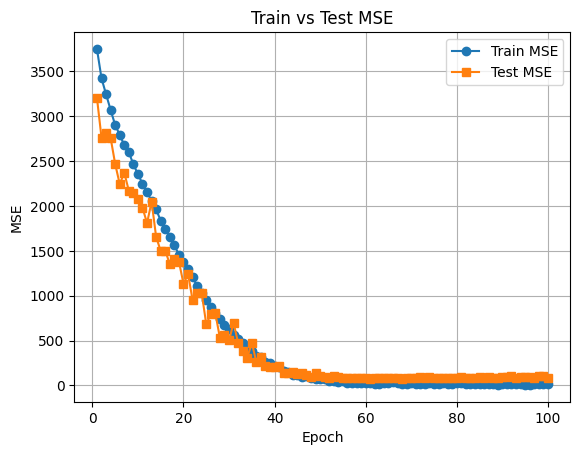

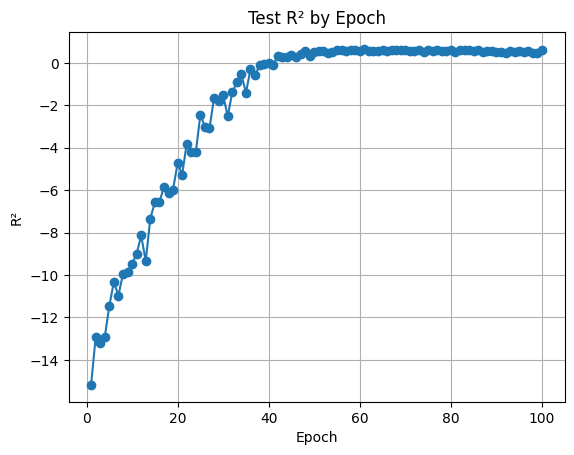

In [33]:


history = train(
    num_epochs=100,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)

In [34]:
# E2E - 0.6039
# Last layer - 0.3815
# Linear probing - -0.1887



In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


# Replace final head: 1 output for regression (no activation here)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, 1)

for p in model.parameters():
    p.requires_grad = False

last_conv = model.layer4[-1].conv2
for p in last_conv.parameters():
    p.requires_grad = True

for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)

# --- 5) Keep BN stats frozen (global eval), but train the two modules we care about ---
model.eval()            # freeze BN running stats across the net
last_conv.train()       # allow grads in last conv
model.fc.train()        # allow grads in classifier


# ----- Loss & optimizer -----
# Choose one:
criterion = nn.MSELoss()                  # or: nn.SmoothL1Loss(beta=1.0)  # Huber
optimizer = optim.Adam(
    [
        {"params": last_conv.parameters(), "lr": 1e-5},
        {"params": model.fc.parameters(), "lr": 1e-4},
    ],
    weight_decay=1e-4,
)

✅ Test MSE: 3185.6655 | RMSE: 56.4417 | MAE: 54.6548 | R²: -15.0897
Epoch [1/100] Avg Train MSE: 3688.1594


✅ Test MSE: 3039.6055 | RMSE: 55.1326 | MAE: 53.2868 | R²: -14.3520
Epoch [2/100] Avg Train MSE: 3572.4548


✅ Test MSE: 2891.2080 | RMSE: 53.7700 | MAE: 51.8799 | R²: -13.6025
Epoch [3/100] Avg Train MSE: 3454.1404


✅ Test MSE: 2785.6206 | RMSE: 52.7790 | MAE: 50.8706 | R²: -13.0692
Epoch [4/100] Avg Train MSE: 3347.4761


✅ Test MSE: 2691.9229 | RMSE: 51.8837 | MAE: 49.9496 | R²: -12.5960
Epoch [5/100] Avg Train MSE: 3279.3608


✅ Test MSE: 2600.0626 | RMSE: 50.9908 | MAE: 49.0285 | R²: -12.1320
Epoch [6/100] Avg Train MSE: 3139.1191


✅ Test MSE: 2511.0395 | RMSE: 50.1103 | MAE: 48.1162 | R²: -11.6824
Epoch [7/100] Avg Train MSE: 3041.0399


✅ Test MSE: 2424.2338 | RMSE: 49.2365 | MAE: 47.2090 | R²: -11.2440
Epoch [8/100] Avg Train MSE: 2941.7590


✅ Test MSE: 2343.1784 | RMSE: 48.4064 | MAE: 46.3580 | R²: -10.8346
Epoch [9/100] Avg Train MSE: 2829.9235


✅ Test MSE: 2256.5250 | RMSE: 47.5029 | MAE: 45.4136 | R²: -10.3969
Epoch [10/100] Avg Train MSE: 2752.9439


✅ Test MSE: 2163.7610 | RMSE: 46.5162 | MAE: 44.3969 | R²: -9.9284
Epoch [11/100] Avg Train MSE: 2641.2903


✅ Test MSE: 2086.6050 | RMSE: 45.6794 | MAE: 43.5218 | R²: -9.5387
Epoch [12/100] Avg Train MSE: 2552.5389


✅ Test MSE: 2017.1314 | RMSE: 44.9125 | MAE: 42.7330 | R²: -9.1878
Epoch [13/100] Avg Train MSE: 2453.4933


✅ Test MSE: 1929.2155 | RMSE: 43.9228 | MAE: 41.7064 | R²: -8.7438
Epoch [14/100] Avg Train MSE: 2369.1721


✅ Test MSE: 1876.1686 | RMSE: 43.3148 | MAE: 41.0841 | R²: -8.4759
Epoch [15/100] Avg Train MSE: 2281.7233


✅ Test MSE: 1796.0369 | RMSE: 42.3797 | MAE: 40.1069 | R²: -8.0712
Epoch [16/100] Avg Train MSE: 2207.2964


✅ Test MSE: 1725.7359 | RMSE: 41.5420 | MAE: 39.2371 | R²: -7.7161
Epoch [17/100] Avg Train MSE: 2120.7917


✅ Test MSE: 1680.5698 | RMSE: 40.9948 | MAE: 38.6829 | R²: -7.4880
Epoch [18/100] Avg Train MSE: 2054.6921


✅ Test MSE: 1604.8462 | RMSE: 40.0605 | MAE: 37.6994 | R²: -7.1055
Epoch [19/100] Avg Train MSE: 1959.2265


✅ Test MSE: 1536.5605 | RMSE: 39.1990 | MAE: 36.8025 | R²: -6.7606
Epoch [20/100] Avg Train MSE: 1870.0408


✅ Test MSE: 1469.5134 | RMSE: 38.3342 | MAE: 35.9117 | R²: -6.4220
Epoch [21/100] Avg Train MSE: 1808.3762


✅ Test MSE: 1405.4269 | RMSE: 37.4890 | MAE: 35.0194 | R²: -6.0983
Epoch [22/100] Avg Train MSE: 1734.0860


✅ Test MSE: 1370.6613 | RMSE: 37.0224 | MAE: 34.5420 | R²: -5.9227
Epoch [23/100] Avg Train MSE: 1686.4384


✅ Test MSE: 1291.7543 | RMSE: 35.9410 | MAE: 33.4074 | R²: -5.5242
Epoch [24/100] Avg Train MSE: 1601.8326


✅ Test MSE: 1259.1405 | RMSE: 35.4844 | MAE: 32.9422 | R²: -5.3595
Epoch [25/100] Avg Train MSE: 1541.6499


✅ Test MSE: 1177.8054 | RMSE: 34.3192 | MAE: 31.7167 | R²: -4.9487
Epoch [26/100] Avg Train MSE: 1461.9475


✅ Test MSE: 1133.1489 | RMSE: 33.6623 | MAE: 31.0383 | R²: -4.7231
Epoch [27/100] Avg Train MSE: 1394.7451


✅ Test MSE: 1092.2127 | RMSE: 33.0486 | MAE: 30.3896 | R²: -4.5164
Epoch [28/100] Avg Train MSE: 1347.9407


✅ Test MSE: 1046.7661 | RMSE: 32.3538 | MAE: 29.6683 | R²: -4.2868
Epoch [29/100] Avg Train MSE: 1285.1696


✅ Test MSE: 1008.2744 | RMSE: 31.7533 | MAE: 29.0189 | R²: -4.0924
Epoch [30/100] Avg Train MSE: 1229.8073


✅ Test MSE: 966.0950 | RMSE: 31.0821 | MAE: 28.3309 | R²: -3.8794
Epoch [31/100] Avg Train MSE: 1185.4371


✅ Test MSE: 911.5064 | RMSE: 30.1912 | MAE: 27.3801 | R²: -3.6037
Epoch [32/100] Avg Train MSE: 1120.6875


✅ Test MSE: 851.9874 | RMSE: 29.1888 | MAE: 26.2936 | R²: -3.3031
Epoch [33/100] Avg Train MSE: 1063.3835


✅ Test MSE: 853.8296 | RMSE: 29.2204 | MAE: 26.3690 | R²: -3.3124
Epoch [34/100] Avg Train MSE: 1028.8383


✅ Test MSE: 794.4933 | RMSE: 28.1868 | MAE: 25.2411 | R²: -3.0127
Epoch [35/100] Avg Train MSE: 974.6662


✅ Test MSE: 766.5278 | RMSE: 27.6862 | MAE: 24.7003 | R²: -2.8715
Epoch [36/100] Avg Train MSE: 927.9083


✅ Test MSE: 728.2317 | RMSE: 26.9858 | MAE: 23.9364 | R²: -2.6780
Epoch [37/100] Avg Train MSE: 879.8453


✅ Test MSE: 719.4979 | RMSE: 26.8235 | MAE: 23.7972 | R²: -2.6339
Epoch [38/100] Avg Train MSE: 845.5394


✅ Test MSE: 651.6462 | RMSE: 25.5274 | MAE: 22.3565 | R²: -2.2912
Epoch [39/100] Avg Train MSE: 798.8755


✅ Test MSE: 635.4994 | RMSE: 25.2091 | MAE: 22.0559 | R²: -2.2097
Epoch [40/100] Avg Train MSE: 771.4227


✅ Test MSE: 612.8992 | RMSE: 24.7568 | MAE: 21.5626 | R²: -2.0955
Epoch [41/100] Avg Train MSE: 717.9096


✅ Test MSE: 586.7287 | RMSE: 24.2225 | MAE: 21.0390 | R²: -1.9634
Epoch [42/100] Avg Train MSE: 685.3051


✅ Test MSE: 567.9855 | RMSE: 23.8324 | MAE: 20.6079 | R²: -1.8687
Epoch [43/100] Avg Train MSE: 656.2995


✅ Test MSE: 541.6169 | RMSE: 23.2727 | MAE: 20.0295 | R²: -1.7355
Epoch [44/100] Avg Train MSE: 623.7046


✅ Test MSE: 519.1024 | RMSE: 22.7838 | MAE: 19.4900 | R²: -1.6218
Epoch [45/100] Avg Train MSE: 595.5431


✅ Test MSE: 483.7806 | RMSE: 21.9950 | MAE: 18.6758 | R²: -1.4434
Epoch [46/100] Avg Train MSE: 553.2215


✅ Test MSE: 478.3041 | RMSE: 21.8702 | MAE: 18.5757 | R²: -1.4157
Epoch [47/100] Avg Train MSE: 542.6657


✅ Test MSE: 441.3809 | RMSE: 21.0091 | MAE: 17.6782 | R²: -1.2293
Epoch [48/100] Avg Train MSE: 521.0066


✅ Test MSE: 412.6540 | RMSE: 20.3139 | MAE: 16.9714 | R²: -1.0842
Epoch [49/100] Avg Train MSE: 474.1080


✅ Test MSE: 394.4265 | RMSE: 19.8602 | MAE: 16.5094 | R²: -0.9921
Epoch [50/100] Avg Train MSE: 452.9208


✅ Test MSE: 362.0142 | RMSE: 19.0267 | MAE: 15.7184 | R²: -0.8284
Epoch [51/100] Avg Train MSE: 430.9326


✅ Test MSE: 361.7663 | RMSE: 19.0202 | MAE: 15.7356 | R²: -0.8272
Epoch [52/100] Avg Train MSE: 399.1551


✅ Test MSE: 340.4901 | RMSE: 18.4524 | MAE: 15.2308 | R²: -0.7197
Epoch [53/100] Avg Train MSE: 387.2175


✅ Test MSE: 325.8519 | RMSE: 18.0514 | MAE: 14.8527 | R²: -0.6458
Epoch [54/100] Avg Train MSE: 372.1299


✅ Test MSE: 301.0002 | RMSE: 17.3494 | MAE: 14.2674 | R²: -0.5202
Epoch [55/100] Avg Train MSE: 344.6618


✅ Test MSE: 274.9279 | RMSE: 16.5810 | MAE: 13.6246 | R²: -0.3886
Epoch [56/100] Avg Train MSE: 325.4742


✅ Test MSE: 291.1304 | RMSE: 17.0625 | MAE: 14.0461 | R²: -0.4704
Epoch [57/100] Avg Train MSE: 310.6562


✅ Test MSE: 285.7697 | RMSE: 16.9047 | MAE: 13.9321 | R²: -0.4433
Epoch [58/100] Avg Train MSE: 291.3615


✅ Test MSE: 250.4362 | RMSE: 15.8252 | MAE: 13.0060 | R²: -0.2649
Epoch [59/100] Avg Train MSE: 271.2119


✅ Test MSE: 239.6995 | RMSE: 15.4822 | MAE: 12.7152 | R²: -0.2106
Epoch [60/100] Avg Train MSE: 261.1120


✅ Test MSE: 249.5352 | RMSE: 15.7967 | MAE: 12.9864 | R²: -0.2603
Epoch [61/100] Avg Train MSE: 260.5786


✅ Test MSE: 225.0729 | RMSE: 15.0024 | MAE: 12.3760 | R²: -0.1368
Epoch [62/100] Avg Train MSE: 228.3652


✅ Test MSE: 220.6638 | RMSE: 14.8548 | MAE: 12.2512 | R²: -0.1145
Epoch [63/100] Avg Train MSE: 223.3537


✅ Test MSE: 215.1194 | RMSE: 14.6669 | MAE: 12.0521 | R²: -0.0865
Epoch [64/100] Avg Train MSE: 207.8159


✅ Test MSE: 202.3244 | RMSE: 14.2241 | MAE: 11.7260 | R²: -0.0219
Epoch [65/100] Avg Train MSE: 194.0907


✅ Test MSE: 208.8785 | RMSE: 14.4526 | MAE: 11.9185 | R²: -0.0550
Epoch [66/100] Avg Train MSE: 198.7448


✅ Test MSE: 185.2275 | RMSE: 13.6098 | MAE: 11.2755 | R²: 0.0645
Epoch [67/100] Avg Train MSE: 183.4284


✅ Test MSE: 187.0932 | RMSE: 13.6782 | MAE: 11.2791 | R²: 0.0551
Epoch [68/100] Avg Train MSE: 177.0738


✅ Test MSE: 179.6909 | RMSE: 13.4049 | MAE: 11.0780 | R²: 0.0924
Epoch [69/100] Avg Train MSE: 174.1072


✅ Test MSE: 167.3473 | RMSE: 12.9363 | MAE: 10.6964 | R²: 0.1548
Epoch [70/100] Avg Train MSE: 155.2470


✅ Test MSE: 163.4184 | RMSE: 12.7835 | MAE: 10.5551 | R²: 0.1746
Epoch [71/100] Avg Train MSE: 147.9289


✅ Test MSE: 164.5864 | RMSE: 12.8291 | MAE: 10.5947 | R²: 0.1687
Epoch [72/100] Avg Train MSE: 140.0661


✅ Test MSE: 166.1405 | RMSE: 12.8895 | MAE: 10.6310 | R²: 0.1609
Epoch [73/100] Avg Train MSE: 131.1426


✅ Test MSE: 156.4237 | RMSE: 12.5069 | MAE: 10.4193 | R²: 0.2100
Epoch [74/100] Avg Train MSE: 124.7134


✅ Test MSE: 161.3255 | RMSE: 12.7014 | MAE: 10.5325 | R²: 0.1852
Epoch [75/100] Avg Train MSE: 130.5373


✅ Test MSE: 151.4844 | RMSE: 12.3079 | MAE: 10.2714 | R²: 0.2349
Epoch [76/100] Avg Train MSE: 124.5251


✅ Test MSE: 152.4179 | RMSE: 12.3458 | MAE: 10.3235 | R²: 0.2302
Epoch [77/100] Avg Train MSE: 107.3740


✅ Test MSE: 148.1326 | RMSE: 12.1710 | MAE: 10.1728 | R²: 0.2518
Epoch [78/100] Avg Train MSE: 100.7984


✅ Test MSE: 146.4647 | RMSE: 12.1023 | MAE: 10.1058 | R²: 0.2603
Epoch [79/100] Avg Train MSE: 101.9008


✅ Test MSE: 138.6600 | RMSE: 11.7754 | MAE: 9.8892 | R²: 0.2997
Epoch [80/100] Avg Train MSE: 102.8804


✅ Test MSE: 133.8510 | RMSE: 11.5694 | MAE: 9.7655 | R²: 0.3240
Epoch [81/100] Avg Train MSE: 96.8302


✅ Test MSE: 132.3507 | RMSE: 11.5044 | MAE: 9.7180 | R²: 0.3315
Epoch [82/100] Avg Train MSE: 93.3396


✅ Test MSE: 132.5412 | RMSE: 11.5127 | MAE: 9.7137 | R²: 0.3306
Epoch [83/100] Avg Train MSE: 75.1505


✅ Test MSE: 128.0131 | RMSE: 11.3143 | MAE: 9.5700 | R²: 0.3535
Epoch [84/100] Avg Train MSE: 95.3880


✅ Test MSE: 128.1116 | RMSE: 11.3186 | MAE: 9.5570 | R²: 0.3530
Epoch [85/100] Avg Train MSE: 76.7602


✅ Test MSE: 123.8937 | RMSE: 11.1308 | MAE: 9.3717 | R²: 0.3743
Epoch [86/100] Avg Train MSE: 83.9831


✅ Test MSE: 124.1803 | RMSE: 11.1436 | MAE: 9.4081 | R²: 0.3728
Epoch [87/100] Avg Train MSE: 68.9421


✅ Test MSE: 128.2470 | RMSE: 11.3246 | MAE: 9.5887 | R²: 0.3523
Epoch [88/100] Avg Train MSE: 77.7005


✅ Test MSE: 126.2406 | RMSE: 11.2357 | MAE: 9.5176 | R²: 0.3624
Epoch [89/100] Avg Train MSE: 60.2693


✅ Test MSE: 124.9725 | RMSE: 11.1791 | MAE: 9.4384 | R²: 0.3688
Epoch [90/100] Avg Train MSE: 63.3467


✅ Test MSE: 124.9347 | RMSE: 11.1774 | MAE: 9.4495 | R²: 0.3690
Epoch [91/100] Avg Train MSE: 62.5261


✅ Test MSE: 124.3867 | RMSE: 11.1529 | MAE: 9.4455 | R²: 0.3718
Epoch [92/100] Avg Train MSE: 70.8124


✅ Test MSE: 125.9964 | RMSE: 11.2248 | MAE: 9.4892 | R²: 0.3636
Epoch [93/100] Avg Train MSE: 55.8046


✅ Test MSE: 123.1244 | RMSE: 11.0961 | MAE: 9.3998 | R²: 0.3781
Epoch [94/100] Avg Train MSE: 65.8957


✅ Test MSE: 124.2911 | RMSE: 11.1486 | MAE: 9.4126 | R²: 0.3722
Epoch [95/100] Avg Train MSE: 59.1440


✅ Test MSE: 122.0194 | RMSE: 11.0462 | MAE: 9.3243 | R²: 0.3837
Epoch [96/100] Avg Train MSE: 58.0634


✅ Test MSE: 121.4554 | RMSE: 11.0207 | MAE: 9.2410 | R²: 0.3866
Epoch [97/100] Avg Train MSE: 51.8933


✅ Test MSE: 122.2200 | RMSE: 11.0553 | MAE: 9.2942 | R²: 0.3827
Epoch [98/100] Avg Train MSE: 54.8017


✅ Test MSE: 121.0589 | RMSE: 11.0027 | MAE: 9.2761 | R²: 0.3886
Epoch [99/100] Avg Train MSE: 60.5676


✅ Test MSE: 122.4656 | RMSE: 11.0664 | MAE: 9.2657 | R²: 0.3815
Epoch [100/100] Avg Train MSE: 58.8108


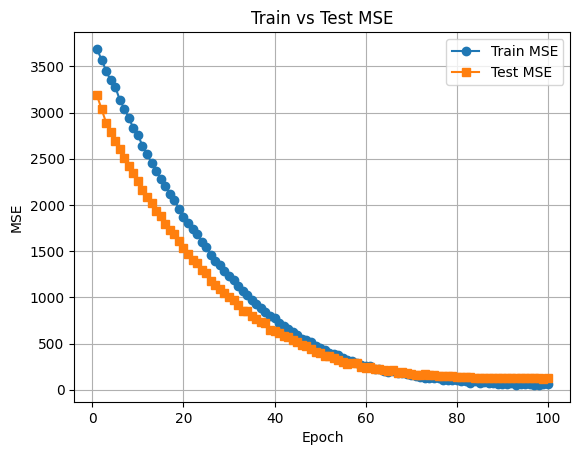

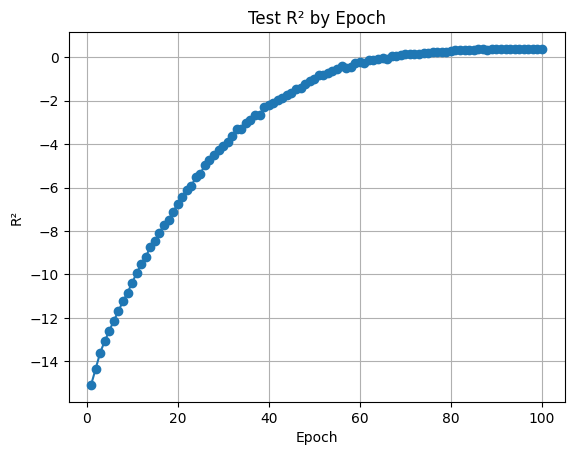

In [36]:


history = train(
    num_epochs=100,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)